<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/3_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will introduce some pre-processing steps common in chemometric pipelines.  

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: May 9, 2024

---

<img src="https://pychemauth.readthedocs.io/en/latest/_images/pipeline.png" height=357 align="right"/>

Pre-processing steps consist of all the steps in the pipeline except the last one, which is the model.

The PyChemAuth [preprocessing subpackage](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth-preprocessing-package) contains a number of different pre-processing steps useful in chemometric applications.The classes discussed below can all be placed in a pipeline as pre-processors like this:
```python
pipe = Pipeline(steps=[
    ('preprocessor_1', PCA_IA(n_components=3)),
    ('preprocessor_2', CorrectedScaler(pareto=True)),
    ('preprocessor_3', SNV(robust=True)),
    ...,
    ('final_model', PLSDA(...))
])

pipe.fit(X_train, y_train)
```

---

In [ ]:
%pip install git+https://github.com/mahynski/pychemauth@main

In [5]:
import sklearn
import pychemauth
import pandas as pd

import watermark
%load_ext watermark
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.5.3
pychemauth: 0.0.0b4
watermark : 2.4.3
sklearn   : 1.3.0



# Scaling and Centering

In many instances, features of the data being used for modeling are recorded in different units, or have very different scales.  Consider the classic wine dataset available from sklearn.

In [5]:
from sklearn.datasets import load_wine
data = load_wine(as_frame=True,)

# print(data['DESCR'])
X = data['data']

In [6]:
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [23]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


The term "autoscaling" refers to the subtraction of a column's mean and division by its sample standard deviation.

$$
X_{\rm auto} = \frac{X - \bar{X}}{s_X}
$$

This puts all features on the same length scale and centers the distribution around 0.  Models involving PCA often require the matrix to be centered (if not scaled), and in fact, in sklearn this is done [automatically](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

In [15]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler(with_mean=True, with_std=True)
X_auto = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [16]:
# mean is 0 and std is 1 now
X_auto.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [18]:
test = (X['alcohol'] - X['alcohol'].mean()) / X['alcohol'].std(ddof=0)
test.describe()

count    1.780000e+02
mean    -8.382808e-16
std      1.002821e+00
min     -2.434235e+00
25%     -7.882448e-01
50%      6.099988e-02
75%      8.361286e-01
max      2.259772e+00
Name: alcohol, dtype: float64

However, this sort of scaling can be strongly influenced by outliers, so a more robust method is to use the median and interquartile range instead.

$$
X_{\rm rob} = \frac{X - {\rm med}(X)}{{\rm iqr}(X)}
$$


In [26]:
from sklearn.preprocessing import RobustScaler

s = RobustScaler(with_centering=True, with_scaling=True)
X_rob = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [28]:
# median is now at 0
X_rob.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,1.780000e+02,178.000000,178.000000,178.000000,178.000000,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000
mean,-0.037553,3.184786e-01,0.018754,-0.001176,0.091662,-0.056631,-6.331158e-02,0.130471,5.128411e-02,1.235201e-01,-0.022372,-0.136564,0.151482
std,0.617359,7.548284e-01,0.789479,0.776643,0.751710,0.591821,5.981190e-01,0.743005,8.176555e-01,7.779483e-01,0.677249,0.576057,0.649964
min,-1.536122,-7.601351e-01,-2.877698,-2.069767,-1.473684,-1.300236,-1.074850e+00,-1.253731,-1.635714e+00,-1.144295e+00,-1.437037,-1.225152,-0.816305
25%,-0.522814,-1.773649e-01,-0.431655,-0.534884,-0.526316,-0.579196,-5.568862e-01,-0.417910,-4.357143e-01,-4.932886e-01,-0.540741,-0.683570,-0.357069
50%,0.000000,-7.502679e-17,0.000000,0.000000,0.000000,0.000000,1.327063e-16,0.000000,-1.587272e-16,1.491862e-16,0.000000,0.000000,0.000000
75%,0.477186,8.226351e-01,0.568345,0.465116,0.473684,0.420804,4.431138e-01,0.582090,5.642857e-01,5.067114e-01,0.459259,0.316430,0.642931
max,1.353612,2.658784e+00,2.503597,2.441860,3.368421,1.442080,1.763473e+00,1.910448,2.892857e+00,2.788591e+00,2.207407,0.989858,2.077399


There are other normalizers available in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) as well.  However, in chemometric applications we often encounter two differences:

1. Some more rigorous practitioners use the [corrected sample standard deviation](https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation) when autoscaling, which reduces the degrees of freedom by one.
2. Pareto scaling divides by the square root of the standard deviation instead, which leaves "some" scale information behind.

PyChemAuth provides a [CorrectedScaler](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth.preprocessing.scaling.CorrectedScaler) and [RobustScaler](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth.preprocessing.scaling.RobustScaler) which are analogs from sklearn's StandardScaler and RobustScaler, but have `biased` and `pareto` options to perform the above modifications.

In [1]:
from pychemauth.preprocessing.scaling import CorrectedScaler, RobustScaler
?CorrectedScaler

In [10]:
s = CorrectedScaler(with_mean=True, with_std=True, pareto=True, biased=False)
X_cor = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [11]:
# std is not exactly 1 now, but mean is 0
X_cor.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-7.584445e-16,-7.983626e-17,-4.241301e-16,-1.596725e-16,0.000000,-7.983626e-17,-3.592632e-16,1.097749e-16,-1.197544e-16,6.985673e-17,9.979533e-17,2.794269e-16,-6.386901e-16
std,9.010142e-01,1.056951e+00,5.237786e-01,1.827447e+00,3.779217,7.911075e-01,9.994292e-01,3.527794e-01,7.565440e-01,1.522592e+00,4.780916e-01,8.426093e-01,1.774563e+01
min,-2.187111e+00,-1.510333e+00,-1.921646e+00,-4.867415e+00,-7.869771,-1.662369e+00,-1.690234e+00,-6.572206e-01,-1.560912e+00,-2.481354e+00,-9.986568e-01,-1.592298e+00,-2.642302e+01
25%,-7.082219e-01,-6.943066e-01,-2.988226e-01,-1.255819e+00,-3.106880,-6.985301e-01,-8.247404e-01,-2.603721e-01,-4.506002e-01,-1.207211e+00,-3.659329e-01,-8.001163e-01,-1.388473e+01
50%,5.480715e-02,-4.459508e-01,-1.244200e-02,2.766799e-03,-0.460829,7.570102e-02,1.057907e-01,-6.194786e-02,-4.745114e-02,-2.417522e-01,1.579313e-02,1.997540e-01,-4.135849e+00
75%,7.512446e-01,7.059471e-01,3.646257e-01,1.097190e+00,1.920616,6.382036e-01,8.462134e-01,2.144288e-01,4.746599e-01,7.499778e-01,3.399988e-01,6.626020e-01,1.341777e+01
max,2.030359e+00,3.277021e+00,1.648565e+00,5.748486e+00,16.473894,2.003378e+00,3.052473e+00,8.451345e-01,2.629194e+00,5.216047e+00,1.574072e+00,1.647637e+00,5.258233e+01


# Filtering

## MSC

The multiplicative scatter correction (MSC) is a filter that was originally intended for use with light scattering data.  It corrects for both additive and multiplicative effects.  

* multiplicative effects - the curve is multiplied by a constant
* additive effects - a constant is added to the curve

---
> ❗ Read the documentation for MSC.
---

In [105]:
from pychemauth.preprocessing.filter import MSC
?MSC

In [35]:
# Load some sample spectra data
df = pd.read_table(
    "https://github.com/mahynski/pychemauth/blob/6b1d0e5da58acdf87d5cdd0bd5edfadbe5ec633e/tests/data/spectra.txt?raw=True",
    sep=' ',
)

In [50]:
df

,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,...,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359
T1,0.145855,0.153409,0.159175,0.165189,0.173052,0.176435,0.184403,0.186026,0.189757,0.187136,...,0.007908,0.007947,0.008470,0.009720,0.007983,0.008838,0.007792,0.005121,0.005958,0.008051
T2,0.162442,0.167085,0.172065,0.177001,0.181469,0.186053,0.192141,0.197744,0.197770,0.195391,...,0.007405,0.007773,0.010051,0.007743,0.006931,0.006804,0.007390,0.008333,0.005683,0.005045
T3,0.134458,0.134200,0.135590,0.139445,0.140511,0.142249,0.144874,0.145783,0.146681,0.147992,...,0.004201,0.005632,0.005079,0.005387,0.006121,0.005356,0.006310,0.003485,0.002699,0.002780
T4,0.104056,0.108399,0.110737,0.112738,0.113899,0.114957,0.119809,0.118663,0.122024,0.121096,...,0.001922,0.005162,0.005157,0.003967,0.004745,0.005169,0.004363,0.004727,0.003921,0.003599
T5,0.167872,0.171446,0.173313,0.175946,0.180587,0.182783,0.186780,0.190731,0.192370,0.190885,...,0.006117,0.007364,0.005561,0.007205,0.006803,0.006698,0.005361,0.006759,0.005421,0.005673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T96,0.065754,0.068029,0.070739,0.073611,0.076127,0.078104,0.081400,0.082984,0.081959,0.084636,...,0.004855,0.002567,0.001328,0.003460,0.004638,0.003670,0.004812,0.004377,0.000875,0.003694
T97,0.140642,0.145233,0.147014,0.149542,0.153356,0.157759,0.162098,0.165036,0.164969,0.163563,...,0.007444,0.007563,0.006567,0.006679,0.006269,0.006389,0.006299,0.006234,0.005592,0.004237
T98,0.070025,0.074017,0.073999,0.077294,0.079827,0.082714,0.084193,0.087853,0.090160,0.085696,...,0.004109,0.002579,0.004986,0.003793,0.003808,0.004464,0.004985,0.002315,0.002146,0.002768
T99,0.069177,0.071417,0.073339,0.075643,0.075861,0.078737,0.081524,0.084222,0.082104,0.083274,...,0.003725,0.002228,0.003511,0.001696,0.002830,0.002080,0.001204,0.002257,0.003208,0.002101


<Axes: >

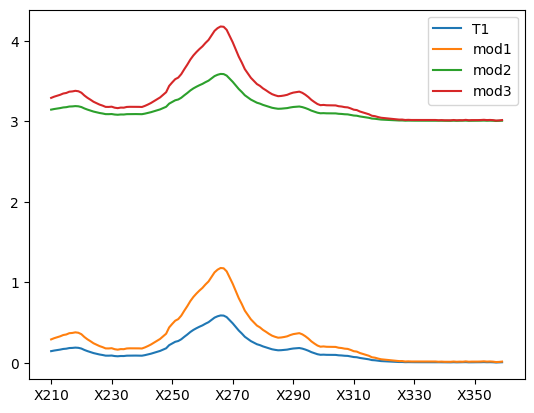

In [99]:
# To illustrate the corrections MSC makes, let's take 1 spectra as a baseline
# and modify it.
baseline = df.loc['T1']

mod1 = baseline * 2 # Multiplicative effect
mod2 = baseline + 3 # Additive effect
mod3 = baseline*2 + 3 # Both

mod1.name = 'mod1'
mod2.name = 'mod2'
mod3.name = 'mod3'

new_set = pd.concat([baseline, mod1, mod2, mod3], axis=1).T

# Let's plot these 4 curves to see what they look like
new_set.T.plot()

<Axes: >

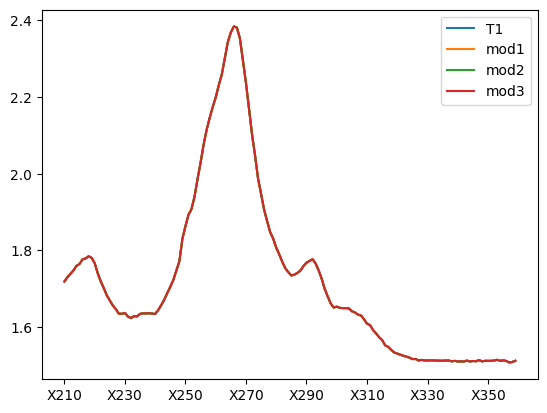

In [104]:
# Let's apply the MSC transformation - they are all coincident now!
pd.DataFrame(
    data=MSC().fit_transform(new_set),
    columns=new_set.columns,
    index=['T1', 'mod1', 'mod2', 'mod3']
).T.plot()

<Axes: >

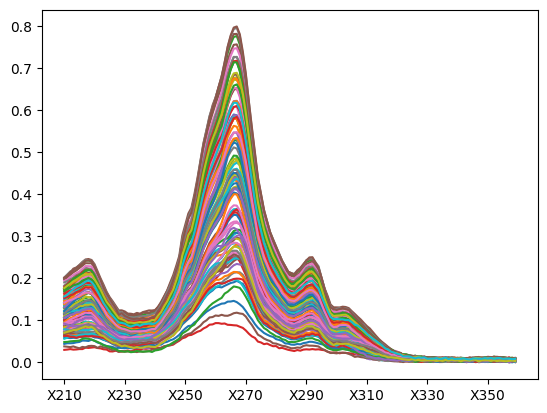

In [52]:
# Plot the entire dataframe
df.T.plot(y=df.index, legend=False)

<Axes: >

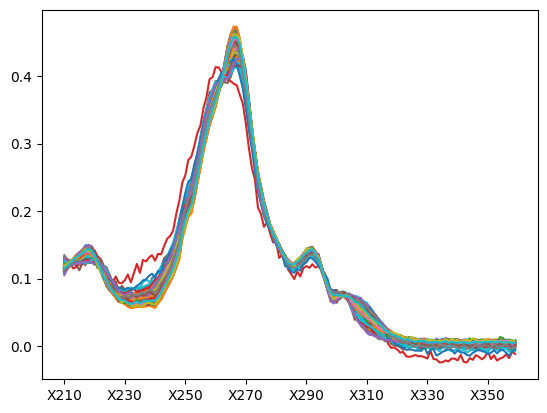

In [108]:
transformer = MSC()
_ = transformer.fit(df)
xformed = pd.DataFrame(
    data=transformer.transform(df),
    columns=df.columns
)

xformed.T.plot(y=xformed.index, legend=False)

## SNV and RNV

The standard normal variates (SNV) is a filter that is usually associated with spectral data as well.  It also corrects for both additive and multiplicative effects, and is generally preferred over MSC.

---
> ❗ Read the documentation for SNV.
---

In [106]:
from pychemauth.preprocessing.filter import SNV
?SNV

<Axes: >

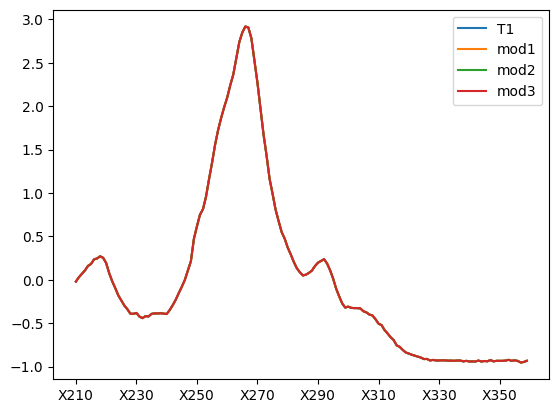

In [107]:
# Let's apply the SNV transformation - they are all coincident now, just like MSC.
pd.DataFrame(
    data=SNV().fit_transform(new_set),
    columns=new_set.columns,
    index=['T1', 'mod1', 'mod2', 'mod3']
).T.plot()

<Axes: >

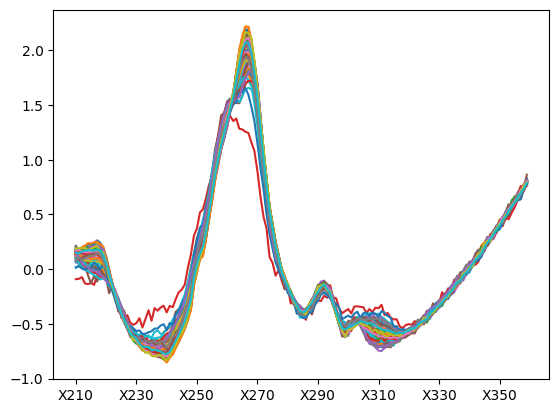

In [114]:
transformer = SNV(q=50, robust=True, detrend=True)
_ = transformer.fit(df)
xformed = pd.DataFrame(
    data=transformer.transform(df),
    columns=df.columns
)

xformed.T.plot(y=xformed.index, legend=False)

In [ ]:
# try this with pgaa data?

## Savitzky-Golay

# Missing Values and Imputation

## Handling Limits of Detection

## Basic Imputation



mean, median, etc.

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute

## Predictive Imputers

### PCA

### PLS

# Class Balancing (SMOTE)

# Feature Selection